# UDA Final

*Spring 2018, Mini 4*

# Part 1 [80 points]
In this question, you will explore how dimensionality reduction techniques may aid in prediction tasks. 

To consider this, we will use the 20 Newsgroup dataset.  The 20 Newsgroups data set is a collection of approximately 18,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. Some of the newsgroups are very closely related to each other (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are highly unrelated (e.g misc.forsale / soc.religion.christian). (http://qwone.com/~jason/20Newsgroups/)  For this question, you will consider a subset of ~4,700 articles from the following 5 categories:
   - `comp.sys.ibm.pc.hardware`
   - `comp.sys.mac.hardware`
   - `rec.sport.baseball`
   - `sci.space`
   - `talk.politics.misc`

You will consider 3 approaches to the task of predicting articles' newsgroups. At the end of this part of the exam, you should be able to fill in this table:

| Dimensionality Reduction Technique | kNN Accuracy |  Optimal k  |  
| :---: | ---
| None (Word Frequencies) | | | 
| Topic Modeling | | | 
| t-SNE | | |  |


## Get the 20 Newsgroups data 
First, load the data.  Note that this data has been split into two sets: one for training (exploratory data analysis and model selection) and the other one for testing (performance evaluation). The split between the train and test set is based upon a messages posted before and after a specific date. (http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)  

We have also loaded labels that indicate each article's newsgroup, and the list of label names.  

In [1]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np

cats = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'rec.sport.baseball', 'sci.space', 'talk.politics.misc']

train_dataset = fetch_20newsgroups(subset='train', shuffle=True, random_state=95865, remove=('headers', 'footers', 'quotes'), categories = cats)
train_documents = train_dataset.data
train_labels = np.array(train_dataset.target)

test_dataset = fetch_20newsgroups(subset='test', shuffle=True, random_state=95865, remove=('headers', 'footers', 'quotes'), categories = cats)
test_documents = test_dataset.data
test_labels = np.array(test_dataset.target)

all_documents = train_documents + test_documents
all_labels = np.array(list(train_labels) + list(test_labels))

label_names = list(train_dataset.target_names)

In [2]:
print(label_names[train_labels[0]])
print("-------------------------------------------------------------------")
print(train_documents[0])

talk.politics.misc
-------------------------------------------------------------------

Cite one of these conflicting statutes.  You keep making
these assertions, but you haven't supported any of them yet.
I am speaking of statutes that conflict with the definition
Larry posted.

Why did you delete the code that Larry posted?

Also, the Model Penal Code made perfect sense to me.  Were you,
perhaps, confused by it?

Also, I am still looking for your definition.  The one you used
clearly indicates that a fetus is not a human being.


Circular arguments are usually very consistent.



Again, your desire for consistency disappears when it does not suit
your needs.  The principle of protecting life is abandoned based
on "action versus inaction."  Not much of a principle.  Suddenly
you recognize that the claim on bodily resources is dependent
on circumstances other than this principle of life.  That's
a very conevnient principle you have there, Matt.


## Approach 1: Baseline (Word Frequencies) [10 points]

In the first approach, you will construct a matrix of word frequencies and use kNN for prediction. More details are given for each task. 

### Construct the document matrix [5 points]

   - Use the `CountVectorizer` from scikit-learn.
   - Set `min_df=2`; this drops words that don't occur in at least 2 documents.
   - Set `stop_words="english"` and `max_df=0.95` to filter out stop-words.
   - Set `max_features=1000` to only consider the 1,000 most frequent terms in the corpus.

In [183]:
# your code here
from sklearn.feature_extraction.text import TfidfVectorizer
vect_obj=TfidfVectorizer(stop_words='english', min_df=50,max_df=0.8)
X=vect_obj.fit_transform(train_documents)
X_test = vect_obj.transform(test_documents)
X_all = vect_obj.transform(all_documents)
# vocab = set(vect_obj.vocabulary_)
# print(len(vocab))

### Model Selection to find the optimal number of neighbors (k) [3 points]
* Train a kNN model to predict the newsgroup category.  
* Use the documents' word frequencies as the features in this model (the x's).  
* Use 5 fold Cross Validation to find the number of neighbors which gives the highest accuracy in predicting the newsgroup.
* Select between k = 1, 2, 5, 10, 25, 100 or 1000


In [184]:
# # your code here
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
num_folds = 5
k_fold = KFold(num_folds)
param_values_knn = [1,2,5,10,25,100,1000]
arg_max_knn = None
max_cross_val_score_knn = -np.inf
x=X
y=np.array(train_labels)
for C in param_values_knn:
    fold_scores=[]
    for train, val in k_fold.split(X):
        knn = KNeighborsClassifier(n_neighbors=C)
        knn.fit(x[train],y[train])
        y_pred = knn.predict(x[val])
        accuracy = accuracy_score(y[val], y_pred)
        fold_scores.append(accuracy)
    cross_val_score_knn = np.mean(fold_scores)
    if cross_val_score_knn > max_cross_val_score_knn:
        max_cross_val_score_knn = cross_val_score_knn
        arg_max_knn = C
            
best_k = arg_max_knn
print("best k:",best_k)
    

best k: 1000


### Model Evaluation [2 points]

* Write code to determine how well the selected model performs on the held out test data.


In [185]:
# your code here
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(x,y)
y_pred_knn = knn.predict(X_test)
y_test_knn=test_labels
accuracy = accuracy_score(test_labels, y_pred_knn)
print("Accuracy",accuracy)

Accuracy 0.67731629393


## Approach 2: Topic Modeling for Dimensionality Reduction  [35 points]

In this approach, you will use topic modeling for dimensionality reduction.  You will again train a k-NN model to predict the newsgroup.  However, in this approach you will first perform topic modeling for dimensionality reduction.  You will then use the documents' distributions over topics as the features (the x's) in the k-NN model.

### Run LDA for k = 2, 3, ... 10 topics [5 points]

* Perform LDA on the entire corpus (training + test documents). 
* Recall that LDA models learn the topics distributions' over words and the documents' distributions over topics.  You will need to access these to compute the coherence metric for the model. Please store these elements for each LDA model that you learn. 
* When learning your LDA models, use the following parameters:
   - Set `max_iter=1`
   - Set `learning_method = "online"` 
   - Set `random_state = 95865` 

In [46]:
# your code here
from sklearn.decomposition import LatentDirichletAllocation
num_topics=10
elements=[]
for k in range(2,num_topics):
    lda = LatentDirichletAllocation(n_components=k, learning_method='online', random_state=95865,max_iter=1)
    lda.fit(X_all)
    elements.append(lda)

### Function to compute topic coherence [10 points]
* We will use coherence to determine the optimal number of topics.  Coherence has similarities to pointwise mutual information (PMI), and research has found that it is a useful metric for selecting the optimal number of topics.  We discussed coherence in class, but have not computed it until now.  


* Coherence is computed as follows:
* Let $D(v)$ be the document frequency of word v (i.e., the number of documents with least one token of type v), and let $D(v, v')$ be the co-document frequency of words v and v' (i.e., the number of documents containing both v and v', not necessarily in sequence):
* Let $V^{(t)} = (v_1^{(t)}, v_2^{(t)}, ... , v_M^{(t)})$ be a list of the M most probable words in topic t.


$$
    \textrm{Coherence for topic t} = \sum_{m=2}^{M}\sum_{l=1}^{m-1}\textrm{score}(v_m^{(t)},v_l^{(t)})\\
    \textrm{score}(v_m^{(t)},v_l^{(t)}) = \frac{D(v_m^{(t)}, v_l^{(t)}) + 1}{D(v_l^{(t)})}\\
    \textrm{Overall coherence of LDA model} = \textrm{Mean coherence of all topics in LDA model}
$$


#### Write a function to compute the overall topic coherence for a LDA model.
* In your function, let M = 10.
* Hint 1: You will need to compute document and co-document frequencies first.
* Hint 2: The inputs to the coherence function should be the document frequencies, the co-document frequencies, and the most probable words for each topic. The output should be the overall coherence of the LDA model.
* Hint 3: It may be helpful to look at the notes from the PMI recitation, which can be found here:  https://gist.github.com/emaadmanzoor/1d06e0751a3f7d39bc6814941b37531d

In [76]:
def compute_cx_cxy(vs):
    cx = Counter()
    cxy = Counter()
    for v in vs:
        for word in v:
            cx[word] += 1
        for x, y in map(sorted, combinations(v, 2)):
            cxy[(x, y)] += 1
    return cx,cxy

def coherence(vs, cx, cxy):
    M=10
    score={}
    for k,v in cxy.items():
        score[k]=(v+1)/cx[k[1]]
    vals=score.values()
    n=len(score.keys())
    return sum(vals)/n

In [81]:
import numpy as np
from collections import Counter
from itertools import combinations

score={}
overall_coherence_lst=[]
for element in elements:
    lst = vect_obj.get_feature_names()
    M=10
    vs=[]
    all_vs =[]
    rows,cols = element.components_.shape
    topic_word_distributions = np.array([topic_word_pseudocounts / np.sum(topic_word_pseudocounts)
                                     for topic_word_pseudocounts in element.components_])
    print("LDA with topic:",rows)
    for topic_idx in range(rows):
        sort_indices = np.argsort(topic_word_distributions[topic_idx])[::-1]
        lst2 = sort_indices[:M]
        top_m =[lst[l] for l in lst2]
        vs.append(top_m)
    cx,cy = compute_cx_cxy(vs)
    overall_coherence=coherence(vs,cx,cy)
    print(overall_coherence)
    print()
    overall_coherence_lst.append(overall_coherence)


LDA with topic: 2
1.9111111111111112

LDA with topic: 3
1.7765151515151516

LDA with topic: 4
1.8218390804597702

LDA with topic: 5
1.9129464285714286

LDA with topic: 6
1.7083333333333333

LDA with topic: 7
1.879365079365079

LDA with topic: 8
1.7613636363636365

LDA with topic: 9
1.6712962962962965



### Compute and plot the topic coherence for each k [10 points]

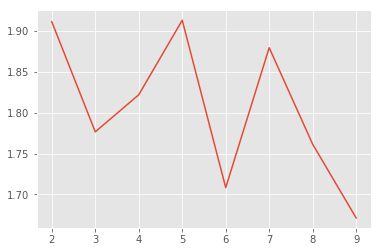

In [84]:
# your code here
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')  # prettier plots
num_topics=10
k_lst = range(2,num_topics)
plt.plot(k_lst,overall_coherence_lst)

### Print the top 10 words for each topic in the best topic model [ 5 points]
* Based on your coherence results, select the optimal number of topics.  
* Note that larger coherence values are better.
* Print the top 10 words for each topic in the selected LDA model

In [88]:
# your code here
k=5
lda = LatentDirichletAllocation(n_components=k, learning_method='online', random_state=95865,max_iter=1)
lda.fit(X_all)
topic_word_distributions = np.array([topic_word_pseudocounts / np.sum(topic_word_pseudocounts)
                                     for topic_word_pseudocounts in lda.components_])
lst = vect_obj.get_feature_names()
for topic_idx in range(k):
    print("===========")
    print('[Topic %d]' % topic_idx)
    sort_indices = np.argsort(topic_word_distributions[topic_idx])[::-1]
    lst2 = sort_indices[:10]
    top_m =[lst[l] for l in lst2]
    for i in top_m:
        print(i)
    print("============")
    print()

[Topic 0]
monitor
simms
rights
oh
17
anybody
sorry
idea
person
source

[Topic 1]
drive
thanks
card
mac
scsi
know
use
does
apple
pc

[Topic 2]
edu
internet
thought
sort
david
article
assume
like
heard
did

[Topic 3]
game
baseball
games
team
year
hit
players
ball
play
season

[Topic 4]
people
don
space
like
just
think
time
know
did
right



### Model Selection to find the optimal number of neighbors (k) [3 points]
* Train a kNN model to predict the newsgroup category.  
* Use the documents' distributions over topics as the features in this model (the x's).  
* Use 5 fold Cross Validation to find the number of neighbors which gives the highest accuracy in predicting the newsgroup.
* Select between k = 1, 2, 5, 10, 25, 100 or 1000


In [161]:
### Partition the Documents' Distribution Over Topics into the Training and Test Set
lda = LatentDirichletAllocation(n_components=k, learning_method='online', random_state=95865,max_iter=1)
lda.fit(X_all)
x_trans=lda.transform(X_all)
app_word_distributions = np.array([app_word_pseudocounts / np.sum(app_word_pseudocounts)
                                     for app_word_pseudocounts in x_trans])
import pandas as pd
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(app_word_distributions,all_labels,test_size=0.2)

num_folds = 5
k_fold = KFold(num_folds)
param_values_knn = [1,2,5,10,25,100,1000]
arg_max_knn = None
max_cross_val_score_knn = -np.inf


for C in param_values_knn:
    fold_scores=[]
    for train, val in k_fold.split(X):
        knn = KNeighborsClassifier(n_neighbors=C)
        knn.fit(X_train[train],y_train[train])
        y_pred = knn.predict(X_train[val])
        accuracy = accuracy_score(y_train[val], y_pred)
        fold_scores.append(accuracy)
    cross_val_score_knn = np.mean(fold_scores)
    if cross_val_score_knn > max_cross_val_score_knn:
        max_cross_val_score_knn = cross_val_score_knn
        arg_max_knn = C
            
best_k = arg_max_knn
print("best k:",best_k)

best k: 100


### Model Evaluation [2 points]

* Write code to determine how well the selected model performs on the held out test data.

In [179]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train,y_train)
y_pred_lda = knn.predict(X_test)
y_test_lda=y_test
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy",accuracy)

Accuracy 0.402763018066


## Approach 3: t-SNE for Dimensionality Reduction [20 points]

In this approach, you will use t-SNE for dimensionality reduction.  You will again train a k-NN model to predict the newsgroup.  However, in this approach you will use PCA and t-SNE for dimensionality reduction. You will then use the 2D t-SNE representation of the documents as the features (the x's) in this k-NN model.

### Perform Dimensionality Reduction [13 points]
* Perform dimensionality reduction on the entire corpus of data (training + test documents).
* Use PCA to project the word frequency matrix down to 30 dimensions.
* Perform t-SNE on this 30 dimensional data. 
   - Set `n_components=2`.
   - Set `perplexity = 40`.
   - Set `random_state = 95865`

In [173]:
# your code here
from sklearn.decomposition import PCA
new_pca = PCA(n_components=30,random_state = 95865)
x_all= X_all.toarray()
print(X_all.shape)
reduced_Data = new_pca.fit_transform(x_all)
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40,random_state = 95865)
tsne2d = tsne.fit_transform(x_all)


(4701, 527)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4701 samples in 0.199s...
[t-SNE] Computed neighbors for 4701 samples in 24.384s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4701
[t-SNE] Computed conditional probabilities for sample 2000 / 4701
[t-SNE] Computed conditional probabilities for sample 3000 / 4701
[t-SNE] Computed conditional probabilities for sample 4000 / 4701
[t-SNE] Computed conditional probabilities for sample 4701 / 4701
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 109.735390
[t-SNE] Error after 1000 iterations: 2.357368


### Plot the t-SNE 2-D representation of the data [2 points]

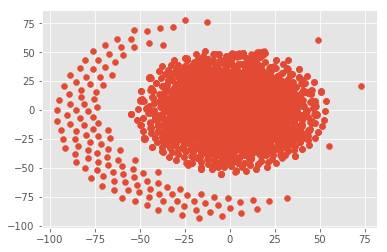

In [174]:
# your code here
plt.scatter(tsne2d[:, 0], tsne2d[:, 1])

In [175]:
tsne2d.shape

(4701, 2)

### Model Selection to find the optimal number of neighbors (k) [3 points]
* Train a k-NN model to predict the newsgroup category.  
* Use the documents' 2D t-SNE representation as the features in this model (the x's).  
* Use 5 fold Cross Validation to find the number of neighbors which gives the highest accuracy in predicting the newsgroup.
* Select between k = 1, 2, 5, 10, 25, 100 or 1000


In [176]:
### Partition the Documents' 2D t-SNE representation into the Training and Test Set
X_train, X_test, y_train, y_test = train_test_split(tsne2d,all_labels,test_size=0.2)

num_folds = 5
k_fold = KFold(num_folds)
param_values_knn = [1,2,5,10,25,100,1000]
arg_max_knn = None
max_cross_val_score_knn = -np.inf


for C in param_values_knn:
    fold_scores=[]
    for train, val in k_fold.split(X):
        knn = KNeighborsClassifier(n_neighbors=C)
        knn.fit(X_train[train],y_train[train])
        y_pred = knn.predict(X_train[val])
        accuracy = accuracy_score(y_train[val], y_pred)
        fold_scores.append(accuracy)
    cross_val_score_knn = np.mean(fold_scores)
    if cross_val_score_knn > max_cross_val_score_knn:
        max_cross_val_score_knn = cross_val_score_knn
        arg_max_knn = C
            
best_k = arg_max_knn
print("best k:",best_k)
# your code here

best k: 1


### Model Evaluation [2 points]

* Write code to determine how well the selected model performs on the held out test data.

In [178]:
# your code here
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train,y_train)
y_pred_tsne = knn.predict(X_test)
y_test_tsne=y_test
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy",accuracy)

Accuracy 0.402763018066


## Interpretation [15 points]

### Summarize Accuracy Results [2 points]
Please fill out the following table:

| Dimensionality Reduction Technique | kNN Accuracy |  Optimal k  |  
| :---: | ---
| None (Word Frequencies) | | | 
| Topic Modeling | | | 
| t-SNE | | |  |


### Show the Confusion Matrices for Each Approach [5 points]

* Please display the confusion matrices for each of the 3 approaches.
* Please normalize these matrices so that they show the percent of articles from each true newsgroup that were classified as each of the 5 categories.  

Confusion Mattrix:
[[300  43  27  15   7]
 [102 208  43  28   4]
 [ 15   5 351  17   9]
 [ 19  17  68 268  22]
 [ 10   6  86  63 145]]


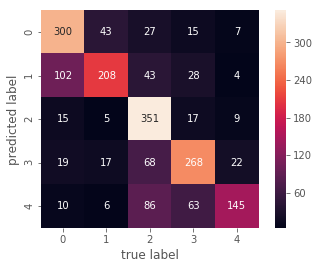

Confusion Mattrix:
[[82 52 31 31 20]
 [39 61 22 29 26]
 [25 29 94 27 26]
 [23 29 41 86 30]
 [13 20 29 20 56]]


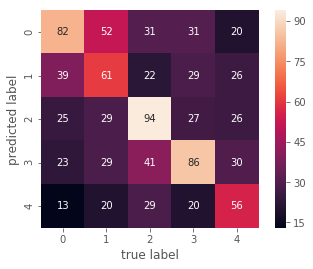

Confusion Mattrix:
[[82 52 31 31 20]
 [39 61 22 29 26]
 [25 29 94 27 26]
 [23 29 41 86 30]
 [13 20 29 20 56]]


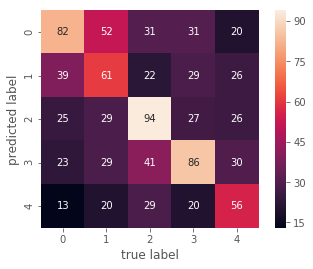

In [188]:
# your code here
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_test_knn, y_pred_knn)
print("Confusion Mattrix:")
print(conf)
import seaborn as sns
%matplotlib inline
fig2=plt.figure()
fig2.add_subplot(111)
sns.heatmap(conf,annot=True,square=True,cbar=True,fmt="d")
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.show()

from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_test_lda, y_pred_lda)
print("Confusion Mattrix:")
print(conf)
import seaborn as sns
%matplotlib inline
fig2=plt.figure()
fig2.add_subplot(111)
sns.heatmap(conf,annot=True,square=True,cbar=True,fmt="d")
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.show()

from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_test_tsne, y_pred_tsne)
print("Confusion Mattrix:")
print(conf)
import seaborn as sns
%matplotlib inline
fig2=plt.figure()
fig2.add_subplot(111)
sns.heatmap(conf,annot=True,square=True,cbar=True,fmt="d")
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.show()

### Short Answer [8 points]

#### 1. What insights about the benefits of the various approaches can you gain from the confusion matrices that were not obvious by just looking at the accuracy metric?

We see that various approches try to classify documents on various news groups with a similar range of accuracy,

#### 2. What is the easiest newsgroup to predict?
The maximum occurances of apaticular news group will be the easiest to predict in the document

#### 3. Why did we perform dimensionality reduction over the entire corpus?  Why doesn't this violate principles of cross validation?
As the data was reallu huge ti help us better visualise the data and still maintain th estructure in data we used PCA and TSNE for dimensionality reduction
as we did split the data and applied CV on reduced dmension data we made sure that it does not violate the principles of CV
1. Logistic -We can try doing Logistic regression and predict as to what an be the most important news group
2. Naieve Bayes -NB can also be used as a baseline for classification
3. SVM classification - SVM also helps in classifying the data well

#### 4. Name 3 other approaches that you would try for this task.  Explain the potential benefits of each of your proposed approaches.  (2-3 sentences per approach)

# Part 2: Deep Learning Architecture [20 points]

In this part, we will consider the architecture of a simple deep learning model for time series.  One way to deal with a 1D time series of numbers is to think of it as an image that just happens to have height 1.  

In this part, we will consider a simple 1 dimensional ConvNet with the architecture input -> conv layer with ReLu activation -> max pooling.  

Suppose that the input is 1 X 7 X 1.  Note that you should interpret these dimensions as Height X Width X Number of Channels, where height is the number of rows, width is the number of columns and channels is the number of colors (e.g. 1 for greyscale). 


For each layer, please indicate the number of parameters that need to be learned, and the shape of the layer's output.

### 1. CONV Layer with ReLu activation [10 points]
* Suppose that 2, 1 X 3 filters are learned.
* Suppose that the amount of zero-padding that is added is 1.
* Assume that we do not use a bias vector.

#### Response:
 Number of parameters: 
 
 Shape of layer output:

### 2. Max Pool Layer [5 points]
* Suppose that 1 filter of size 1x2 is applied. That is, every MAX operation would in this case be taking a max over a 1X2 region.

#### Response: 

Number of parameters:

Shape of layer output:

### 3. Interpretation [5 points]

#### 3a) Consider the rightmost pixel of the final output: what is the leftmost pixel in the input image that it depends on?  
* Assume that the leftmost pixel has index value of 0.

#### 3b) How does this depend on the size of the conv layer filter and the size of the original image?  
* Assume that the max pool layer remains unchanged.